In [1]:
import sys
#!{sys.executable} -m pip install wordcloud
#!{sys.executable} -m pip install xgboost
#!{sys.executable} -m pip install nltk
#!{sys.executable} -m pip install textblob
#!{sys.executable} -m pip install --upgrade xgboost





In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re as r
import nltk
import numpy as np
#nltk.download('all')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.utils import resample
import plotly.figure_factory as ff
import joblib as j
import xgboost as xgb


In [3]:
url = 'https://raw.githubusercontent.com/breanna-s/Mental-Health-Chatbot/refs/heads/main/Combined%20Data.csv'
df = pd.read_csv(url)
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
df.isnull().sum()


Unnamed: 0      0
statement     362
status          0
dtype: int64

In [5]:
df.dropna(how='any', axis=0, inplace=True)
df.isnull().sum()

Unnamed: 0    0
statement     0
status        0
dtype: int64

In [6]:
# Counts for each Mental Health status
df["status"].value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

In [7]:
# get number of characters as this will be ussed to eliminate outliers later
df['num_chars'] = df['statement'].str.len()
print(df['num_chars'].describe())

count    52681.000000
mean       578.713863
std        846.269078
min          2.000000
25%         80.000000
50%        317.000000
75%        752.000000
max      32759.000000
Name: num_chars, dtype: float64


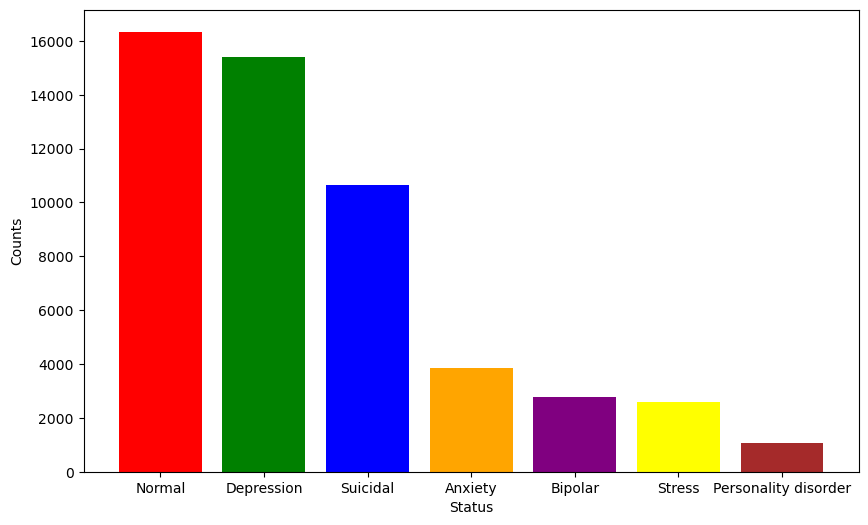

In [8]:
# Visualization of distribution of each Mental Health Status
s_count = df["status"].value_counts()
colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'brown'] 

plt.figure(figsize=(10,6))
plt.bar(s_count.index, s_count.values, color=colors[:len(s_count)])
plt.xlabel("Status")
plt.ylabel("Counts")
plt.show()

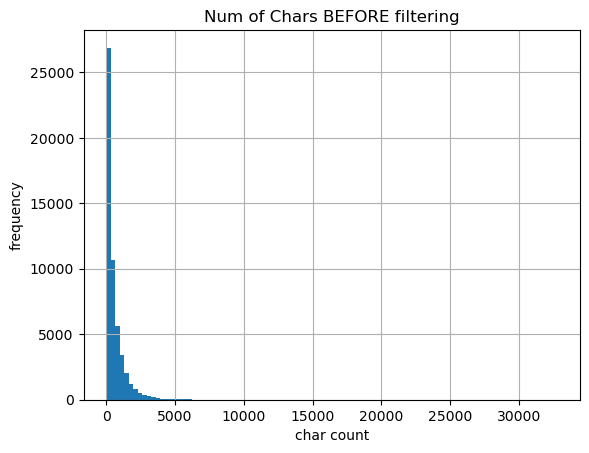

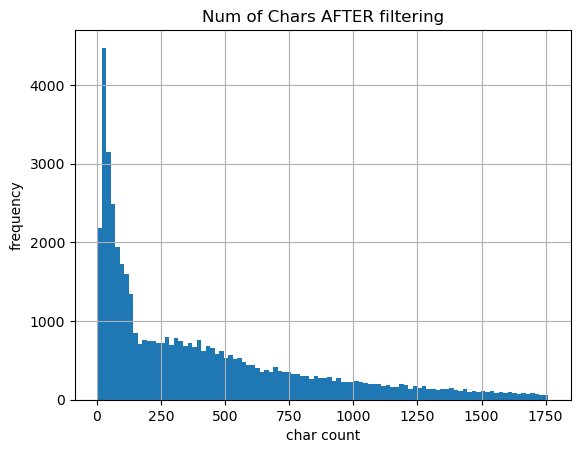

,Unnamed: 0,num_chars
count,52681.000000,52681.000000
mean,26365.706042,578.713863
std,15235.065306,846.269078
min,0.000000,2.000000
25%,13180.000000,80.000000
50%,26350.000000,317.000000
75%,39522.000000,752.000000
max,53042.000000,32759.000000


In [9]:
#remove outliers of the lower quarter percentile and upper quarter percentile of the number of characters

df['num_chars'].hist(bins=100)
plt.title('Num of Chars BEFORE filtering')
plt.xlabel('char count')
plt.ylabel('frequency')
plt.show()



lower_q = df['num_chars'].quantile(.25)
upper_q = df['num_chars'].quantile(.75)
q_range = upper_q - lower_q

lower_bound = lower_q - 1.5 * q_range
upper_bound = upper_q + 1.5 * q_range

filtered_df = df[(df['num_chars'] >= lower_bound) & (df['num_chars'] <= upper_bound) ]
filtered_df['num_chars'].hist(bins=100)
plt.title('Num of Chars AFTER filtering')
plt.xlabel('char count')
plt.ylabel('frequency')
plt.show()
df.describe()


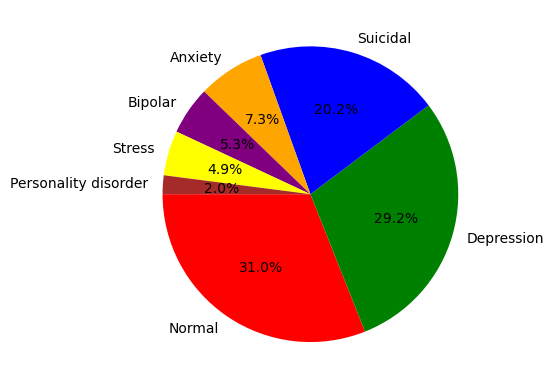

In [10]:
#data is skewed so will need to fix that at some point, shown as pie chart
colors =  ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'brown'] 
plt.pie(s_count, labels=s_count.index, autopct='%.1f%%', colors=colors, startangle=180)
random_statements = df.groupby("status")["statement"].apply(lambda x: x.sample(n=1)) #this prevents a random print for some reason

   
#status: ('Suicidal', 36299) isnt suicidal, sh
#statement: @realDonaldTrump It already is! At least in France one doesn't die/loss everything when get sick &amp; have at least 1â¦ https://t.co/QYN3ku1Q8T

In [11]:
df['sentence_count'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))
df[['num_chars', 'sentence_count']].describe()

,num_chars,sentence_count
count,52681.000000,52681.000000
mean,578.713863,6.280215
std,846.269078,10.688388
min,2.000000,1.000000
25%,80.000000,1.000000
50%,317.000000,3.000000
75%,752.000000,8.000000
max,32759.000000,1260.000000


In [12]:
#get random values for each of the status types as examples
random_statements = df.groupby("status")["statement"].apply(lambda x: x.sample(n=1))
for status, statement in random_statements.items():
    print(f"status: {status}")
    print(f"statement: {statement}", end="\n\n-----------------------------------------------\n")

status: ('Anxiety', 35044)
statement: Doctor doesn't know what's wrong/MRI canceled:( Over the past month I've experienced pulsatile tinnitus in one ear along with ear and headaches. Some days I feel no symtoms, others it's horrible but the pulsing sound remains. I also feel this weird tingling on the side of my head (same as the effected ear). I also have this "weird" feeling, like I'm on a strong pain pill. Though, when I go outside I don't feel nearly as bad honestly, being inside starts alot of my symtoms. The doctor believes it's idiopathic intracranial Hypertension or a venal issue. May I add that when I press on the area around my jugular, the sound fades or if I lay on the side that pulses it all goes away as well. I have yet to have a MRI, as it was canceled😔 I'm scared it's a tumor, please help. My mind has been racing for a week on what this may be. 
I'm 18/Female

-----------------------------------------------
status: ('Bipolar', 46197)
statement: Seeking advice on a close

In [13]:
import re
#convert the statements all to lower case to keep tokenization consistent
df['statement'] = df['statement'].str.lower()
#remove puncuation, markdown, urls, special chars
def remove_special_inputs(text):
    text = re.sub(r"http[s]?://\S+","",text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', "", text)
    # Remove handles (that start with '@')
    text = re.sub(r"@\w+","",text)
    # Remove punctuation and other special characters
    text = re.sub(r"[^\w\s]","",text)
    return text
df['statement_no_punc'] = df['statement'].apply(remove_special_inputs)
df.head()


,Unnamed: 0,statement,status,num_chars,sentence_count,statement_no_punc
0,0,oh my gosh,Anxiety,10,1,oh my gosh
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...
2,2,"all wrong, back off dear, forward doubt. stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...
3,3,i've shifted my focus to something else but i'...,Anxiety,61,1,ive shifted my focus to something else but im ...
4,4,"i'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...


In [14]:
#need to tokenize each the elements in the statement column of the data
#use the word_tokenize from nltk to divide the string into individual words
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['tokens'] = df['statement_no_punc'].apply(lambda x: remove_stopwords(x))
df.sample(5)


,Unnamed: 0,statement,status,num_chars,sentence_count,statement_no_punc,tokens
21221,21221,"tonight, right now, i am going to try to talk ...",Suicidal,984,23,tonight right now i am going to try to talk to...,tonight right going try talk last people belie...
7192,7192,so i just found out i got banned from omegle. ...,Depression,491,7,so i just found out i got banned from omegle d...,found got banned omegle understand whatever su...
6427,6427,"what's more, i want to off",Normal,26,1,whats more i want to off,whats want
52925,52925,i had a mini win ! hello everyone i hope you’r...,Anxiety,1703,16,i had a mini win hello everyone i hope youre ...,mini win hello everyone hope youre okay playin...
52549,52549,i feel like i'm having a heart attack again i'...,Anxiety,379,5,i feel like im having a heart attack again im ...,feel like im heart attack im 23 years old suff...


In [15]:
df.sample(5)
df.shape

(52681, 7)

In [16]:


#data augmentation to increase data set size, do this by
#translating it to another language and then back
#kind of like how on google translate it may not exactly translate
#Original Text: "The cat is on the mat."
#Translated to French: "Le chat est sur le tapis."
#Back Translated to English: "The cat is on the carpet."
# can add this in later
def augment(text):
    try:
        blob = TextBlob(text)
        translate = blob.translate(to='fr').translate(to='en')
        return str(translate)
    except:
        return text
df['augment_statement'] = df['statement'].apply(augment)
augmented_df = df[['statement', 'status']].copy()
augmented_df['statement'] = df['augment_statement']
df = pd.concat([df, augmented_df])
df.head()
df.shape


    

(105362, 8)

In [17]:
df['statement_no_punc'] = df['statement'].apply(remove_special_inputs)
df['tokens'] = df['statement_no_punc'].apply(lambda x: remove_stopwords(x))
df.head()
df.shape

(105362, 8)

In [18]:
#need to stem the the tokens to eliminate prefix and suffixes to get the root word
#this will standardize the words used in the training data for the model, 
#this takes about a minute to run fyi
stemmer = PorterStemmer() #initialize stemmer

def token_stemming(tokens):
  return ''.join(stemmer.stem(str(token)) for token in tokens)

df['tokens_stem'] = df['tokens'].apply(token_stemming)

df.sample(5)

,Unnamed: 0,statement,status,num_chars,sentence_count,statement_no_punc,tokens,augment_statement,tokens_stem
43706,43706.0,waiting waiting waiting for a phone call that ...,Normal,99.0,1.0,waiting waiting waiting for a phone call that ...,waiting waiting waiting phone call may mean ac...,waiting waiting waiting for a phone call that ...,waiting waiting waiting phone call may mean ac...
28889,NaN,"hi /r/relationships, i'm hoping you can give m...",Stress,NaN,NaN,hi rrelationships im hoping you can give me so...,hi rrelationships im hoping give perspective l...,NaN,hi rrelationships im hoping give perspective l...
50282,50282.0,manic ep? what are the signs? i feel like my o...,Bipolar,249.0,4.0,manic ep what are the signs i feel like my ove...,manic ep signs feel like obsession small incid...,manic ep? what are the signs? i feel like my o...,manic ep signs feel like obsession small incid...
8785,NaN,for context i am the most depressed i have eve...,Suicidal,NaN,NaN,for context i am the most depressed i have eve...,context depressed ever earlier tonight decided...,NaN,context depressed ever earlier tonight decided...
25640,25640.0,"i have two friends, a and b, a told me to watc...",Suicidal,1012.0,17.0,i have two friends a and b a told me to watch ...,two friends b told watch anime watched attack ...,"i have two friends, a and b, a told me to watc...",two friends b told watch anime watched attack ...


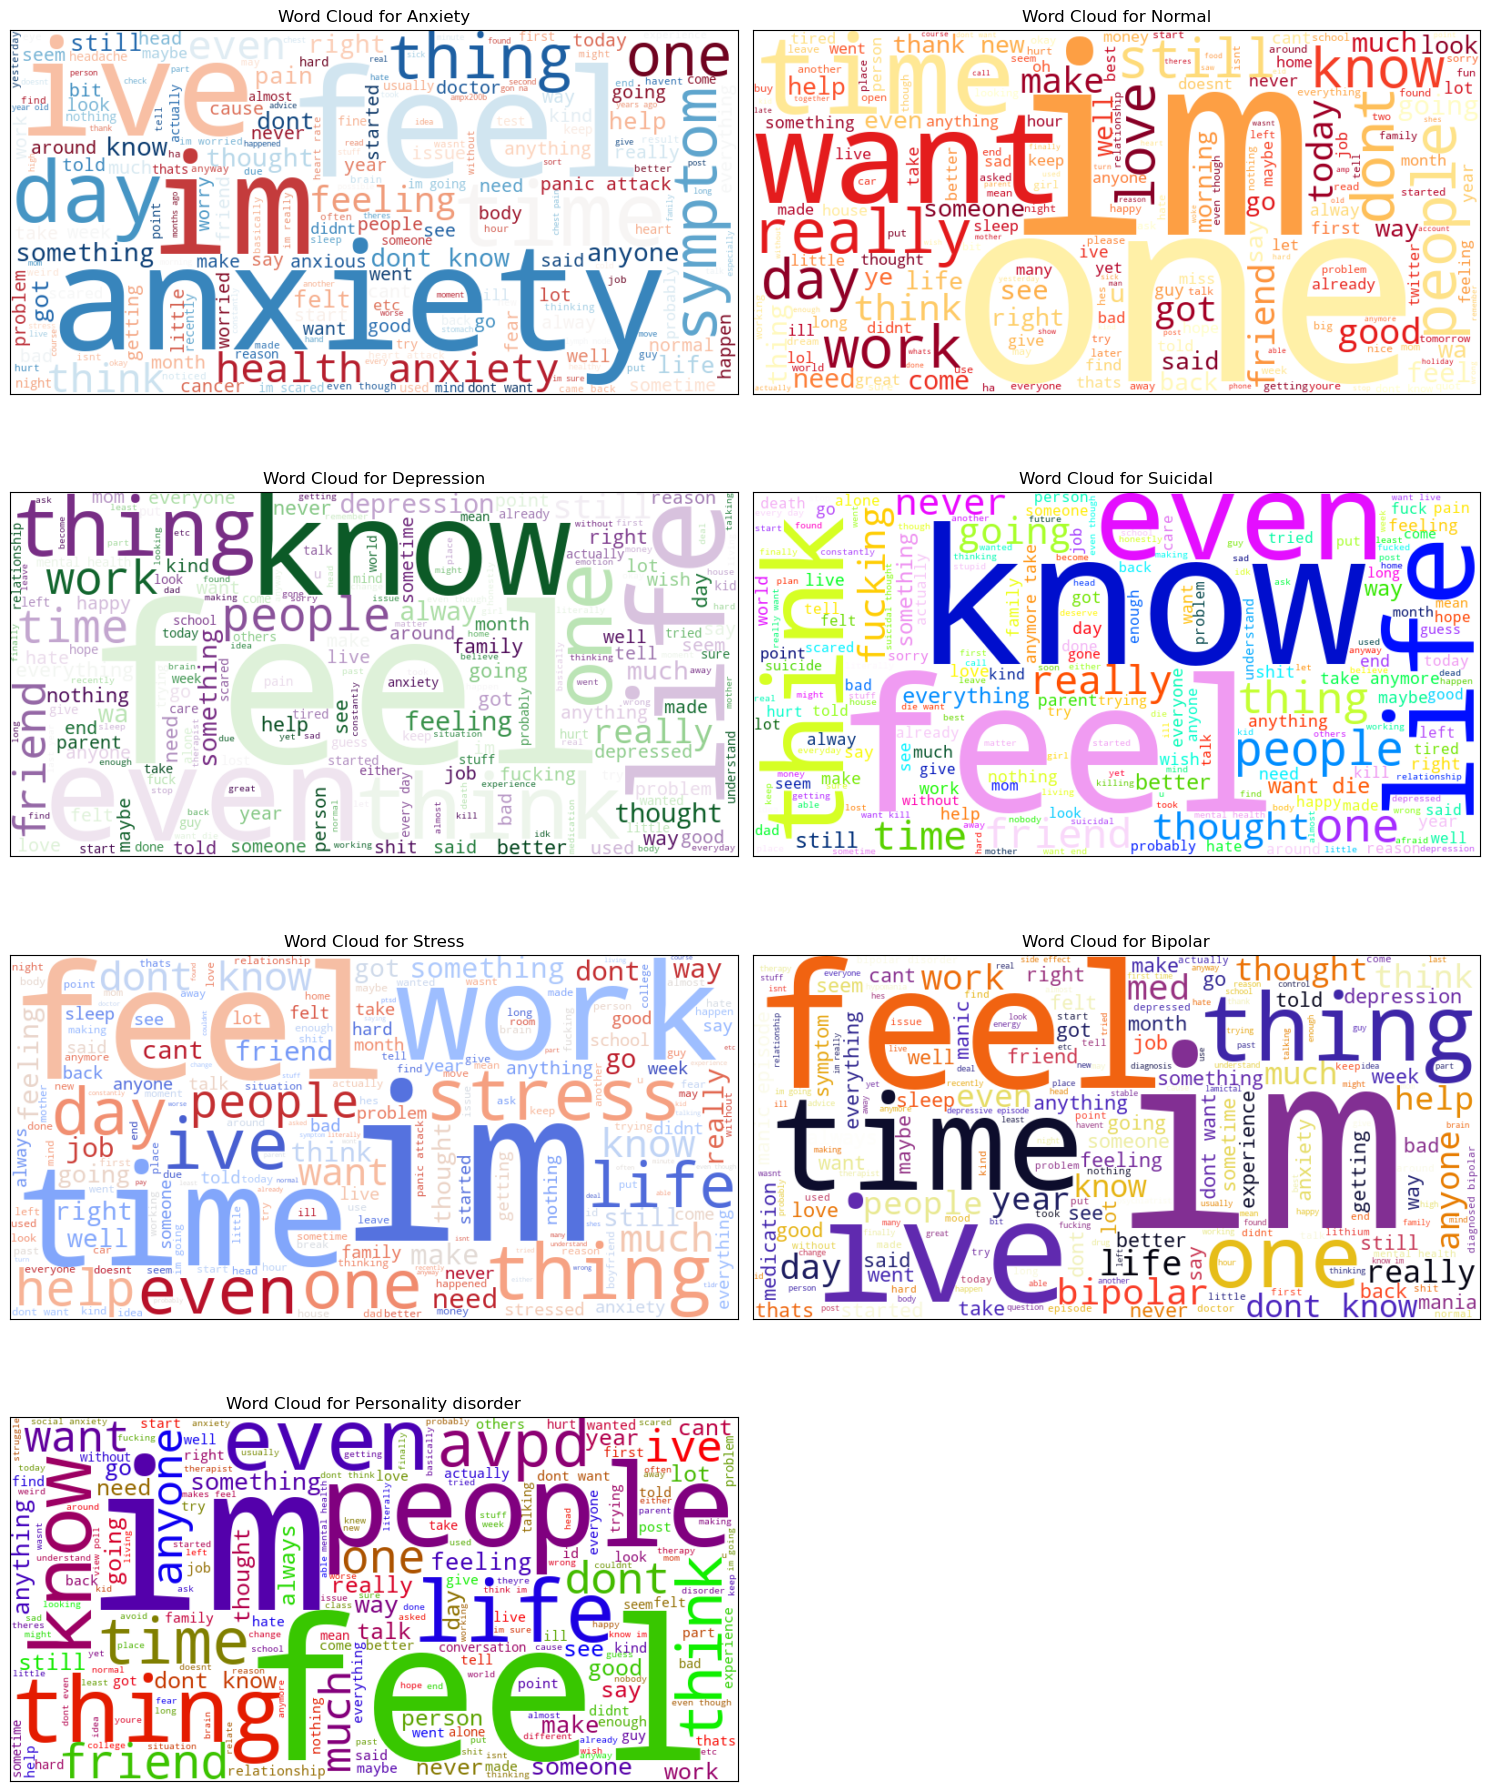

In [19]:
#word collages can help show the common words for each condition
#colormap =  RdBu

unique_status = df['status'].unique()
plt.figure(figsize=(15, 45))
color_map_array = ['RdBu', 'YlOrRd', 'PRGn_r','gist_ncar_r', 'coolwarm', 'CMRmap', 'brg']
for i, status in enumerate(unique_status):
  tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ''.join(x)).tolist())
  word_cloud = WordCloud(width=800, height=400, background_color='white', colormap=color_map_array[i]).generate(tokens_data)
  axes = plt.subplot(len(unique_status) // 2 + 1, 2, i+1)
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.title(f'Word Cloud for {status}')
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=-.85)
plt.show()


In [20]:
#set the x values we will be examining, the stemmed tokens, word and, char count
#we compare these against the status as the y values
x = df[['tokens_stem', 'num_chars', 'sentence_count']]
y = df['status']
print(y)


0        Anxiety
1        Anxiety
2        Anxiety
3        Anxiety
4        Anxiety
          ...   
53038    Anxiety
53039    Anxiety
53040    Anxiety
53041    Anxiety
53042    Anxiety
Name: status, Length: 105362, dtype: object


In [21]:
#encode the y values, status, to be represented as numerical values. turn anxiety to 0
#IF YOU GET AN ERROR RUNNING THIS, RUN THE CELL ABOVE AND TRY AGAIN, IF THIS FAILS IT OVERWRITES Y AND 
#PULLS A JUPYTER NOTEBOOK MOMENT WHERE Y SHOULDNT BE MODIFIED BUT AGAIN JUPYTER NOTEBOOKS 🤬
#encoder = LabelEncoder()
#y = encoder.fit_transform(y.values)
#print(y)


In [22]:
#we use train_test_split function on data
#idk when you are supposed to use a new cell in jupyter notebook typically
#im just doing it after doing an operation or function on some data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42)

In [23]:
#now we will convert the text to features 
#we do this via tfidf or Term Frequency-Inverse Document Frequency
#we determine how important a given word is to a status by determining the frequency of a word in the TOTAL dataset
#if word t in data set d the term frequency is equal to (num of t) / (num of words in d)
vector = TfidfVectorizer(max_features=25000)
x_train_tfid = vector.fit_transform(x_train['tokens_stem'])
x_test_tfid = vector.transform(x_test['tokens_stem'])

#now need the numerical features of the training and testing data
x_train_num = x_train[['num_chars', 'sentence_count']].values
x_test_num = x_test[['num_chars', 'sentence_count']].values

#lastly combine the tfid with the numerical values
combined_x_train = hstack([x_train_tfid, x_train_num])
combined_x_test = hstack([x_test_tfid, x_test_num])

print('feature word count: ', len(vector.get_feature_names_out())) #should be 50000
combined_x_train.shape #should be 42144, 50002

feature word count:  25000


(84289, 25002)

In [24]:
#this takes about 6.5 minutes to run with max_features = 50000, change the max_features to 10k (in above cell) for it to be about 4 minutes

param_grid = {
    'C' : [100] #100 is the best score and this decreases run time
}
model = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_tfid, y_train)
best_model = grid_search.best_estimator_


In [25]:
y_pred = best_model.predict(x_test_tfid)
print(y_pred)

['Suicidal' 'Normal' 'Stress' ... 'Stress' 'Suicidal' 'Suicidal']


In [26]:
print('Best param_grid value(s): ', grid_search.best_params_)
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Classification_report:')
print(classification_report(y_test, y_pred))


Best param_grid value(s):  {'C': 100}
Accuracy score:  0.9196127746405353
Classification_report:
                      precision    recall  f1-score   support

             Anxiety       0.95      0.95      0.95      1523
             Bipolar       0.96      0.95      0.96      1109
          Depression       0.90      0.90      0.90      6204
              Normal       0.96      0.97      0.96      6505
Personality disorder       0.95      0.95      0.95       424
              Stress       0.93      0.89      0.91      1080
            Suicidal       0.86      0.87      0.86      4228

            accuracy                           0.92     21073
           macro avg       0.93      0.92      0.93     21073
        weighted avg       0.92      0.92      0.92     21073



In [27]:
cm = confusion_matrix(y_test, y_pred)
fig = ff.create_annotated_heatmap(
    z=cm,
    x=list(set(y_test)),
    y=list(set(y_test)),
    annotation_text=cm,
    colorscale='Viridis'
)
fig.update_layout(title='Confusion Matrix')
fig.show()


In [28]:
#was using this for xgb but not needed anymore without xgb
#now need random sampling
#r = RandomOverSampler(random_state=42)
#x_train_r, y_train_r = r.fit_resample(combined_x_train, y_train)
#x_train_r.shape

In [29]:
#i gave up on this bc after 30 minutes it still hadnt finished
#this is a gradient booster algorithm.
#idk what it actually does bc ML seems to just be importing modules to
#the machine learning part
#xgb_clf = XGBClassifier(learing_rate=.5, max_depth =7, n_estimators=500, random_state=42, tree_method ="hist")
#xgb_clf.fit(x_train_r, y_train_r)
#y_pred = xgb_clf.predict(combined_x_test)

#xgb_clf = XGBClassifier(learning_rate=0.5, max_depth=7, n_estimators=500, random_state=101, n_jobs=-1)
# Train the classifier on the resampled training data
#xgb_clf.fit(x_train_r, y_train_r)
# Predict the labels on the test data
#y_pred = xgb_clf.predict(combined_x_test)

In [30]:
def predict_custom_input(text):
    # Preprocess the input text
    stemmer = PorterStemmer()
    text = remove_special_inputs(text)  # Ensure this function is correctly defined
    processed_text = ' '.join([stemmer.stem(word) for word in word_tokenize(text.lower())])

    # Transform and predict using the original vectorizer
    input_vector = vector.transform([processed_text])  # Use the original vectorizer
    prediction = best_model.predict(input_vector)

    print("Processed input:", processed_text)
    print("Input vector:", input_vector.toarray())  # Print the vector for debugging
    print("Prediction:", prediction)

# Test with a variety of inputs
predict_custom_input("I feel overwhelmed")
predict_custom_input("I am very happy and excited.")
predict_custom_input("i am going to kill myself.")
predict_custom_input("i cant get out of bed im so sad feeling life knowing")


Processed input: i feel overwhelm
Input vector: [[0. 0. 0. ... 0. 0. 0.]]
Prediction: ['Depression']
Processed input: i am veri happi and excit
Input vector: [[0. 0. 0. ... 0. 0. 0.]]
Prediction: ['Normal']
Processed input: i am go to kill myself
Input vector: [[0. 0. 0. ... 0. 0. 0.]]
Prediction: ['Normal']
Processed input: i cant get out of bed im so sad feel life know
Input vector: [[0. 0. 0. ... 0. 0. 0.]]
Prediction: ['Depression']


In [31]:
df = pd.read_csv(url)

In [32]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [33]:
df.tail()
df['status'].value_counts()


status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

In [34]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [35]:
df.sample(3)

,statement,status
46653,feeling guilty starting to come down off a sho...,Bipolar
11709,I think about killing myself a lot in the midd...,Suicidal
6600,"""Courage is the word of truth to raise one's s...",Normal


In [36]:
df['status'].value_counts()

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

In [37]:
df['status'].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [38]:
df['status'].nunique()

7

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB


In [40]:
df.isna().sum()

statement    362
status         0
dtype: int64

In [41]:
df.shape

(53043, 2)

In [42]:
df.dropna(inplace=True)

In [43]:
df.shape

(52681, 2)

In [44]:
max_count=df['status'].value_counts().max()
max_count

16343

In [45]:
def resample_func(df):
    max_count=df['status'].value_counts().max()

    df_resampled = pd.DataFrame()
    
    for status in df['status'].unique():
        df_class = df[df['status'] == status]
        if len(df_class) < max_count:
            df_class_resampled = resample(df_class, replace=True, n_samples=max_count, random_state=42)
            df_resampled = pd.concat([df_resampled, df_class_resampled])
        else:
            df_resampled = pd.concat([df_resampled, df_class])
    return df_resampled

df = resample_func(df)

In [46]:
df.sample(5)

,statement,status
13643,Everyone I talk to these days tells me to live...,Suicidal
27088,the only time i feel relieved is when I am goi...,Suicidal
36202,"200 words over with still more to write, lame....",Normal
51054,it's killing me I spend my days ruminating abo...,Personality disorder
21,Successfully online at 9am. Even sleeping in a...,Anxiety


In [47]:
df.status.value_counts()

status
Anxiety                 16343
Normal                  16343
Depression              16343
Suicidal                16343
Stress                  16343
Bipolar                 16343
Personality disorder    16343
Name: count, dtype: int64

In [48]:
df.shape

(114401, 2)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114401 entries, 52349 to 51085
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   statement  114401 non-null  object
 1   status     114401 non-null  object
dtypes: object(2)
memory usage: 2.6+ MB


In [50]:
df.isna().sum()

statement    0
status       0
dtype: int64

In [51]:
stemmer = PorterStemmer()
def text_preprocessing(x):
    l = []
    text = re.sub(r"http[s]?://\S+","",x.lower())
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', "", x.lower())
    # Remove handles (that start with '@')
    text = re.sub(r"@\w+","",x.lower())
    # Remove punctuation and other special characters
    text = re.sub(r"[^\w\s]","",x.lower())
    for i in text.split():
        l.append(stemmer.stem(i.lower()))
        
    return ' '.join(l)

In [52]:
df['statement'] = df['statement'].apply(text_preprocessing)

In [53]:
x=df['statement']
y=df['status']

In [54]:
x_train,  x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=.2)

In [55]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(91520,) (91520,) (22881,) (22881,)


In [56]:
vectorizer = TfidfVectorizer()
x_train_tfid = vectorizer.fit_transform(x_train)
x_test_tfid = vectorizer.transform(x_test)

In [57]:
print(x_train_tfid.shape,x_test_tfid.shape)

(91520, 51083) (22881, 51083)


In [58]:
print(x_train_tfid)

  (0, 31849)	0.07170700184540524
  (0, 4306)	0.08289724682752532
  (0, 17652)	0.035897775724327896
  (0, 47370)	0.04863480352115629
  (0, 27952)	0.05361068749845166
  (0, 22973)	0.07386360072765173
  (0, 43988)	0.07059958457254117
  (0, 26343)	0.08971221844171094
  (0, 5389)	0.0469648591837628
  (0, 26803)	0.040083646059194906
  (0, 8657)	0.06298348420896085
  (0, 8305)	0.03511335160648387
  (0, 41583)	0.09079732421164308
  (0, 23031)	0.04368967825236861
  (0, 49630)	0.09869449092360522
  (0, 20685)	0.09410893342777839
  (0, 25129)	0.03839072563216771
  (0, 22798)	0.08759891026271265
  (0, 44909)	0.0641290129359503
  (0, 21592)	0.09608969460163558
  (0, 4664)	0.06430079745801165
  (0, 32905)	0.04407679333273894
  (0, 4824)	0.12533789014166616
  (0, 12971)	0.07696716601970323
  (0, 49451)	0.0386405061136565
  :	:
  (91518, 11894)	0.0350387158010285
  (91518, 23217)	0.09037090636333774
  (91518, 49116)	0.03176856968537055
  (91518, 4096)	0.1464713710098126
  (91518, 48326)	0.028959773819

In [59]:
rf = RandomForestClassifier()
rf.fit(x_train_tfid, y_train)
#takes about 5 min to run

RandomForestClassifier()

In [60]:
y_pred = rf.predict(x_test_tfid)
ytr_pred = rf.predict(x_train_tfid)
print("Test accuracy: ",accuracy_score(y_test,y_pred))
print("Train accuracy: ",accuracy_score(y_train,ytr_pred))
print("Precision Test accuracy: ",precision_score(y_test,y_pred,average='weighted'))
print("Precision Train accuracy: ",precision_score(y_train,ytr_pred,average='weighted'))

Test accuracy:  0.952974083300555
Train accuracy:  0.9997705419580419
Precision Test accuracy:  0.9526808779725751
Precision Train accuracy:  0.999770714848328


In [61]:
j.dump(vectorizer, 'rf_vectorizer.pkl')
j.dump(rf, 'rf_model.pkl')

['rf_model.pkl']

In [62]:
custom_input = 'It shows I have posted but I cannot find my post back here Am I not allowed to post here?'

In [63]:
custom_input = text_preprocessing(custom_input)
custom_input

'it show i have post but i cannot find my post back here am i not allow to post here'

In [64]:
def prediction(x):
    vec=vectorizer.transform([custom_input])
    result = rf.predict(vec)[0]
    return result

In [65]:
prediction(custom_input)

'Normal'

In [66]:
ext=ExtraTreesClassifier()
ext.fit(x_train_tfid,y_train)

ExtraTreesClassifier()

In [67]:
ypred=ext.predict(x_test_tfid)
ytr_pred=ext.predict(x_train_tfid)
print("Test accuracy: ",accuracy_score(y_test,ypred))
print("Train accuracy: ",accuracy_score(y_train,ytr_pred))
print("Precision Test accuracy: ",precision_score(y_test,ypred,average='weighted'))
print("Precision Train accuracy: ",precision_score(y_train,ytr_pred,average='weighted'))

Test accuracy:  0.9511822035750186
Train accuracy:  0.9997705419580419
Precision Test accuracy:  0.9513176998385489
Precision Train accuracy:  0.999770714848328


In [68]:
j.dump(vectorizer, 'ext_vectorizer.pkl')
j.dump(ext, 'ext_model.pkl')

['ext_model.pkl']